## Coursera IBM Capstone Project

This notebook is made sollely for the purpose of the Coursera IBM Capstone Project.

This notebook is trying to solve an imagined, but very common need on real estate market in Croatia. Hopefuly, it will help actors on both ends of real estate transactions, notably private traders, but also the ones providing real estate services, such as real estate agenceies.

Let's first explain the niche that we are trying to fill with this solution, as well as the accompyning assumptions.  
Zagreb is a Croatian capitol with allmost 1m citizens and is situated on Croatian inland. The climate is continental. Just like many other CE countries, Croatia is rather centralized country, meaning, all the major companies are situated in Zagreb, but also all goverment agencies, universities, etc.   
Split is the second largest town in Croatia, and is situated south, on Adriatic coast and has mediteranian climate. It's main economic branch is a tourism and has one of the biggest seaports for travelers in Europe.  
Due to all of this, there are many people from Zagreb that wants to buy real estate in Split, espetialy when they reach pension so that they can enjoy in wormer climate of Adriatic coastline. On the other hand, there are lot's of people from Split that are not involved in tourism, and are drawn to Zagreb,  either due to some business reasons, a bit cheaper real estates, or some other reasons.

In this notebook, the following data is used:
1. List of the neighborhoods in Zagreb and Split.
2. Geocoordinates of the neighborhoods in Zagreb and Split.
3. Top venues of neighborhoods.

The idea is to use unsupervised machine learning to create clusters of neighborhoods so that we can compare them and provide insight as service for actors on real estate market. After cleaning up the data, we will specifically use Kmeans machine learning for creating clusters of neighborhoods. Top venues of neighborhoods is going to be used as data for neigborhood comparison. When collecting venues, a 800 meter radius is used around the center coordinates of the districts. The number of collected venues is limited to 100 per districts. Silhouette score metrichs will be used for choosing the optimal number of clusters. The final considerations will be made using that optimal cluster number.

### Importing required libraries

In [5]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

! pip install folium==0.5.0
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

print('Libraries imported.')

     |████████████████████████████████| 79 kB 7.5 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=1201595346ce6c5e1fbf43d5e3407c60bb1e7242426b6fc906410d76e9730b41
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Libraries imported.


### We will use geolocator variable throughout this notebook

In [6]:
geolocator = Nominatim(user_agent="foursquare_agent")

# 1. Getting the basic neighborhoods data

### Loading neighborhoods in Split from url=https://www.split.hr/DesktopModules/Bring2mind/DMX/API/Entries/Download?language=hr-HR&Command=Core_Download&EntryId=6080&PortalId=0

In [7]:
split_gk = pd.read_excel('https://www.split.hr/DesktopModules/Bring2mind/DMX/API/Entries/Download?language=hr-HR&Command=Core_Download&EntryId=6080&PortalId=0',
                        header=1)
split_gk

,R.BR.,NAZIV MJESNOG ODBORA / GRADSKOG KOTARA / GRADSKE ČETVRTI,SJEDIŠTE,INTERNETSKA STRANICA JEDINICE MJESNE SAMOUPRAVE,TAJNIK/ICA,ADRESA E-POŠTE JEDINICE MJESNE SAMOUPRAVE,TELEFON JEDINICE MJESNE SAMOUPRAVE
0,1,GK BAČVICE,VIŠKA 7,www.split.hr,ANKICA MIKULIĆ,ankica.mikulic@split.hr,021 682 502
1,2,GK BLATINE ŠKRAPE,POLJIČKA CESTA 31,www.split.hr,DANICA PERKOVIĆ,danica.perkovic@split.hr,021 682 504
2,3,GK BOL,SLOBODE 24,www.split.hr,VESNA BALEN,vesna.balen@split.hr,021 310 377
3,4,GK BRDA,MOSTARSKA 17,www.split.hr,SNJEŽANA DRAŽIĆ,snjezana.drazic@split.hr,021 310367
4,5,GK GRAD,BERNARDINOVA 1,www.split.hr,NIKOLA BAKIĆ,nikola.bakic@split.hr,021 682 506
5,6,GK GRIPE,MATICE HRVATSKE 16,www.split.hr,ANTONIJA PIRIĆ,antonija.piric@split.hr,021 310 355
6,7,GK KMAN,ŠIBENSKA 27,www.split.hr,ELVIRA KROLO,elvira.krolo@split.hr,021 682 508
7,8,GK KOCUNAR,MOSEĆKA 56,www.split.hr,KATIJA ČUKUŠIĆ,katija.cukusic@split.hr,021 682 510
8,9,GK LOKVE,ŠIŽGORIĆEVA 5,www.split.hr,HERTA JUKIĆ,herta.jukic@split.hr,021 682 512
9,10,GK LOVRET,GUNDULIĆEVA 11,www.split.hr,SLAVICA TOMAŠ,slavica.tomas@split.hr,021 310 379


### Since we don't need other columns, let's get rid of them

In [8]:
split_gk = split_gk[['NAZIV MJESNOG ODBORA / GRADSKOG KOTARA / GRADSKE ČETVRTI']].copy()
split_gk

,NAZIV MJESNOG ODBORA / GRADSKOG KOTARA / GRADSKE ČETVRTI
0,GK BAČVICE
1,GK BLATINE ŠKRAPE
2,GK BOL
3,GK BRDA
4,GK GRAD
5,GK GRIPE
6,GK KMAN
7,GK KOCUNAR
8,GK LOKVE
9,GK LOVRET


### Rename column so it will be uniformal

In [9]:
split_gk.rename(columns={'NAZIV MJESNOG ODBORA / GRADSKOG KOTARA / GRADSKE ČETVRTI':'Neighborhood'}, inplace = True) 
split_gk

,Neighborhood
0,GK BAČVICE
1,GK BLATINE ŠKRAPE
2,GK BOL
3,GK BRDA
4,GK GRAD
5,GK GRIPE
6,GK KMAN
7,GK KOCUNAR
8,GK LOKVE
9,GK LOVRET


### MO's are not acctualy neighborhoods in Split, so, let's discard them

In [10]:
split_gk = split_gk[split_gk['Neighborhood'].str.startswith('GK ') == True].copy()
split_gk

,Neighborhood
0,GK BAČVICE
1,GK BLATINE ŠKRAPE
2,GK BOL
3,GK BRDA
4,GK GRAD
5,GK GRIPE
6,GK KMAN
7,GK KOCUNAR
8,GK LOKVE
9,GK LOVRET


### Using previously initialized geolocator variable, this function will provide us a latitude and longitude for every neighborhood in Split

In [11]:
def get_lat_long_4_split(row):
    address = row['Neighborhood'].split('GK ')[-1] + ', Split, Croatia'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

### Apply get_lat_long_4_split function for all rows in dataframe

In [12]:
split_gk['lat_long'] = split_gk.apply(get_lat_long_4_split, axis=1)
split_gk

,Neighborhood,lat_long
0,GK BAČVICE,"[43.5038434, 16.4472256]"
1,GK BLATINE ŠKRAPE,"[43.5077835, 16.4602295]"
2,GK BOL,"[43.2605186, 16.6520192]"
3,GK BRDA,"[43.5244055, 16.4691728]"
4,GK GRAD,"[43.5088227, 16.4391915]"
5,GK GRIPE,"[43.5081044, 16.4526551]"
6,GK KMAN,"[43.5182442, 16.4559894]"
7,GK KOCUNAR,"[43.5184036, 16.4663294]"
8,GK LOKVE,"[43.5105815, 16.4586079]"
9,GK LOVRET,"[43.514789, 16.4385284]"


### Loading neighborhoods in Zagreb from https://hr.wikipedia.org/wiki/Zagreba%C4%8Dke_gradske_%C4%8Detvrti

In [13]:
zagreb_gk = pd.read_html('https://hr.wikipedia.org/wiki/Zagreba%C4%8Dke_gradske_%C4%8Detvrti',attrs={"cellpadding": "4"})
zagreb_gk[0]

,Unnamed: 0,Gradska četvrt,Površina(km²),Stanovništvo (2011.),Gustoćastanovnika
0,1.0,Donji grad,3,37.024,12.341
1,2.0,Gornji grad - Medveščak,10,30.962,3.096
2,3.0,Trnje,7,42.282,6.040
3,4.0,Maksimir,14,48.902,3.493
4,5.0,Peščenica - Žitnjak,35,56.487,1.614
5,6.0,Novi Zagreb - istok,17,59.055,3.474
6,7.0,Novi Zagreb - zapad,63,58.103,922.000
7,8.0,Trešnjevka - sjever,6,55.425,9.238
8,9.0,Trešnjevka - jug,10,66.674,6.667
9,10.0,Črnomerec,24,38.546,1.606


In [14]:
zagreb_gk = zagreb_gk[0]

### Remove last row, since it represents sum

In [15]:
zagreb_gk = zagreb_gk.iloc[:-1, :]
zagreb_gk = zagreb_gk.copy()

### Rename column so it will be uniformal

In [16]:
zagreb_gk.rename(columns={'Gradska četvrt':'Neighborhood'}, inplace = True) 
zagreb_gk

,Unnamed: 0,Neighborhood,Površina(km²),Stanovništvo (2011.),Gustoćastanovnika
0,1.0,Donji grad,3,37.024,12.341
1,2.0,Gornji grad - Medveščak,10,30.962,3.096
2,3.0,Trnje,7,42.282,6.040
3,4.0,Maksimir,14,48.902,3.493
4,5.0,Peščenica - Žitnjak,35,56.487,1.614
5,6.0,Novi Zagreb - istok,17,59.055,3.474
6,7.0,Novi Zagreb - zapad,63,58.103,922.000
7,8.0,Trešnjevka - sjever,6,55.425,9.238
8,9.0,Trešnjevka - jug,10,66.674,6.667
9,10.0,Črnomerec,24,38.546,1.606


### Since we don't need other columns, let's get rid of them

In [17]:
zagreb_gk = pd.DataFrame(zagreb_gk['Neighborhood'])
zagreb_gk

,Neighborhood
0,Donji grad
1,Gornji grad - Medveščak
2,Trnje
3,Maksimir
4,Peščenica - Žitnjak
5,Novi Zagreb - istok
6,Novi Zagreb - zapad
7,Trešnjevka - sjever
8,Trešnjevka - jug
9,Črnomerec


### Using previously initialized geolocator variable, this function will provide us a latitude and longitude for every neighborhood in Zagreb

In [18]:
def get_lat_long_4_zagreb(row):
    address = row['Neighborhood'] + ', Zagreb, Croatia'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

### Apply get_lat_long_4_split function for all rows in dataframe

In [19]:
zagreb_gk['lat_long'] = zagreb_gk.apply(get_lat_long_4_zagreb, axis=1)
zagreb_gk

,Neighborhood,lat_long
0,Donji grad,"[45.8098781, 15.9770807]"
1,Gornji grad - Medveščak,"[45.8399258, 15.975095536608798]"
2,Trnje,"[45.762893, 16.13841]"
3,Maksimir,"[45.8333119, 16.0101508]"
4,Peščenica - Žitnjak,"[45.81203395, 16.0080265471029]"
5,Novi Zagreb - istok,"[45.7595202, 16.0079686]"
6,Novi Zagreb - zapad,"[45.7765324, 15.9720813]"
7,Trešnjevka - sjever,"[45.8011083, 15.9388318]"
8,Trešnjevka - jug,"[45.79828835, 15.947751]"
9,Črnomerec,"[45.8183009, 15.9385808]"


### Let's add town information, and split latitude and longitude in separate columns

In [20]:
zagreb_gk['Town'] = 'Zagreb'
split_gk['Town'] = 'Split'
full_towns_df = zagreb_gk.append(split_gk)
full_towns_df.reset_index(drop=True, inplace=True)
full_towns_df['latitude'] = [tmp_row[0] for tmp_row in full_towns_df['lat_long']]
full_towns_df['longitude'] = [tmp_row[1] for tmp_row in full_towns_df['lat_long']]
full_towns_df.drop(['lat_long'], axis=1, inplace=True)
full_towns_df

,Neighborhood,Town,latitude,longitude
0,Donji grad,Zagreb,45.809878,15.977081
1,Gornji grad - Medveščak,Zagreb,45.839926,15.975096
2,Trnje,Zagreb,45.762893,16.138410
3,Maksimir,Zagreb,45.833312,16.010151
4,Peščenica - Žitnjak,Zagreb,45.812034,16.008027
5,Novi Zagreb - istok,Zagreb,45.759520,16.007969
6,Novi Zagreb - zapad,Zagreb,45.776532,15.972081
7,Trešnjevka - sjever,Zagreb,45.801108,15.938832
8,Trešnjevka - jug,Zagreb,45.798288,15.947751
9,Črnomerec,Zagreb,45.818301,15.938581


# 2. Using Foursquare API to get venues so we can augment neighborhood data

### Hidde my credentails using hidden_cell

In [21]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: 1BI24KSMPUOG3YHITZOXJCRBGFPT4JSSMUEL13YJROEOY4XT
CLIENT_SECRET:RCOWK2HRZJTASW1JWTDPZIXBRGEJ1LQIH3ARIVQNP41IYBLY


### Create function that well provide us venue data in python list 

In [22]:
def get_venues(towns, names, latitudes, longitudes, radius=800):    
    venues_list=[]
    for town, name, lat, lng in zip(towns, names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            town,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    return venues_list

### Call get_venues (...) function. Use input params from 'full_towns_df'

In [23]:
st_zg_venues = get_venues(towns=full_towns_df['Town'], names=full_towns_df['Neighborhood'], latitudes=full_towns_df['latitude'], longitudes=full_towns_df['longitude'])
new_venue_list = list()
for tmp_st_zg_venues in st_zg_venues:
    for venue in tmp_st_zg_venues:
        new_venue_list.append(venue)
new_venue_list

[('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Trg Nikole Šubića Zrinskog | Zrinjevac',
  45.810243645100215,
  15.978109413861207,
  'Plaza'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Quahwa',
  45.811029876939294,
  15.975470896679635,
  'Café'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Heritage Croatian Food',
  45.81081,
  15.979922,
  'Comfort Food Restaurant'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Buzz Bar Zagreb',
  45.80893868618315,
  15.974638871006078,
  'Bar'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Korica',
  45.8075492835984,
  15.974862717852943,
  'Bakery'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Zagrebačko kazalište mladih (ZKM)',
  45.811198655998,
  15.976042350202558,
  'Theater'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15.9770807,
  'Express Bar',
  45.81198737800094,
  15.97928524737915,
  'Coffee Shop'),
 ('Zagreb',
  'Donji grad',
  45.8098781,
  15

### Create pandas dataframe of nearby venues

In [24]:
nearby_venues = pd.DataFrame(columns = ['Town', 'Neighborhood', 
              'Neighborhood Latitude', 
              'Neighborhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category'], data = new_venue_list)
nearby_venues

,Town,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Zagreb,Donji grad,45.809878,15.977081,Trg Nikole Šubića Zrinskog | Zrinjevac,45.810244,15.978109,Plaza
1,Zagreb,Donji grad,45.809878,15.977081,Quahwa,45.811030,15.975471,Café
2,Zagreb,Donji grad,45.809878,15.977081,Heritage Croatian Food,45.810810,15.979922,Comfort Food Restaurant
3,Zagreb,Donji grad,45.809878,15.977081,Buzz Bar Zagreb,45.808939,15.974639,Bar
4,Zagreb,Donji grad,45.809878,15.977081,Korica,45.807549,15.974863,Bakery
...,...,...,...,...,...,...,...,...
1460,Split,GK ŽNJAN,43.504547,16.490784,Pizzeria Bepina,43.506512,16.488084,Pizza Place
1461,Split,GK ŽNJAN,43.504547,16.490784,Duilovo,43.501846,16.493233,Beach
1462,Split,GK ŽNJAN,43.504547,16.490784,Plodine,43.509166,16.493281,Grocery Store
1463,Split,GK ŽNJAN,43.504547,16.490784,Tommy,43.506504,16.483621,Grocery Store


In [28]:
print('There are {} uniques categories in Zagreb and Split.'.format(len(nearby_venues['Venue Category'].unique())))

There are 153 uniques categories in Zagreb and Split.


In [29]:
print('There are {} uniques categories in Zagreb.'.format(len(nearby_venues[nearby_venues['Town'] == 'Zagreb']['Venue Category'].unique())))

There are 108 uniques categories in Zagreb.


In [30]:
print('There are {} uniques categories in Split.'.format(len(nearby_venues[nearby_venues['Town'] == 'Split']['Venue Category'].unique())))

There are 104 uniques categories in Split.


### Performing one-hot encoding to analyze neighbourhoods

In [31]:
# one hot encoding
st_zagreb_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood and town column back to dataframe
st_zagreb_onehot['Neighborhood'] = nearby_venues['Neighborhood'] 
st_zagreb_onehot['Town'] = nearby_venues['Town'] 
st_zagreb_onehot

,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,...,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store,Town
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Zagreb
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Zagreb
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Zagreb
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Zagreb
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Zagreb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Split
1461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Split
1462,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Split
1463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Split


### Let's put 'Town' and 'Neighborhood' columns in front

In [32]:
fixed_columns = ['Town', 'Neighborhood'] + [item for item in list(st_zagreb_onehot.columns) if item not in ['Neighborhood', 'Town']]
fixed_columns

['Town',
 'Neighborhood',
 'American Restaurant',
 'Art Gallery',
 'Art Museum',
 'Asian Restaurant',
 'Athletics & Sports',
 'BBQ Joint',
 'Bakery',
 'Bar',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Beach Bar',
 'Bed & Breakfast',
 'Beer Garden',
 'Big Box Store',
 'Bistro',
 'Board Shop',
 'Boarding House',
 'Boat or Ferry',
 'Bookstore',
 'Breakfast Spot',
 'Brewery',
 'Burger Joint',
 'Burrito Place',
 'Bus Station',
 'Cafeteria',
 'Café',
 'Campground',
 'Candy Store',
 'Casino',
 'Chinese Restaurant',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'Comfort Food Restaurant',
 'Cosmetics Shop',
 'Creperie',
 'Cupcake Shop',
 'Department Store',
 'Dessert Shop',
 'Diner',
 'Donut Shop',
 'Drugstore',
 'Eastern European Restaurant',
 'Electronics Store',
 'Escape Room',
 'Exhibit',
 'Eye Doctor',
 'Falafel Restaurant',
 'Farmers Market',
 'Fast Food Restaurant',
 'Field',
 'Fish Market',
 'Flea Market',
 'Food',
 'Food & Drink Shop',
 'Food Court',
 'Furniture / H

### Let's see our onehot dataframe

In [33]:
st_zagreb_onehot = st_zagreb_onehot[fixed_columns]
st_zagreb_onehot.head()

,Town,Neighborhood,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,Zagreb,Donji grad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Zagreb,Donji grad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Zagreb,Donji grad,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Zagreb,Donji grad,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Zagreb,Donji grad,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Aggregating venues for all neighbourhoods using 'mean' function

In [34]:
st_zagreb_onehot_grouped = st_zagreb_onehot.groupby(['Town','Neighborhood']).mean().reset_index()
st_zagreb_onehot_grouped

,Town,Neighborhood,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,Split,GK BAČVICE,0.00,0.000000,0.00,0.000000,0.010870,0.000000,0.010870,0.043478,...,0.000000,0.000000,0.000000,0.0,0.000000,0.010870,0.032609,0.00,0.000000,0.000000
1,Split,GK BLATINE ŠKRAPE,0.00,0.000000,0.00,0.021739,0.000000,0.000000,0.000000,0.108696,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.021739,0.00,0.000000,0.000000
2,Split,GK BOL,0.00,0.000000,0.00,0.000000,0.000000,0.027027,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,Split,GK BRDA,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,Split,GK GRAD,0.00,0.010000,0.00,0.000000,0.000000,0.000000,0.020000,0.050000,...,0.000000,0.000000,0.010000,0.0,0.000000,0.010000,0.020000,0.00,0.020000,0.000000
5,Split,GK GRIPE,0.00,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.054545,...,0.000000,0.000000,0.000000,0.0,0.000000,0.018182,0.000000,0.00,0.000000,0.000000
6,Split,GK KMAN,0.00,0.000000,0.00,0.000000,0.038462,0.000000,0.000000,0.076923,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,Split,GK KOCUNAR,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.076923,0.153846,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,Split,GK LOKVE,0.00,0.000000,0.00,0.025000,0.000000,0.000000,0.000000,0.075000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025000,0.00,0.000000,0.000000
9,Split,GK LOVRET,0.00,0.010638,0.00,0.010638,0.000000,0.000000,0.031915,0.042553,...,0.000000,0.000000,0.000000,0.0,0.000000,0.010638,0.021277,0.00,0.021277,0.000000


### Create the function that gets 'num_top_venues' top venues for each neighborhood, omitting the 'Town' and 'Neighborhood' columns

In [35]:
def get_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

### Get the top 10 venues dataframe

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Town', 'Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Town'] = st_zagreb_onehot_grouped['Town']
neighborhoods_venues_sorted['Neighborhood'] = st_zagreb_onehot_grouped['Neighborhood']

for ind in np.arange(st_zagreb_onehot_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 2:] = get_most_common_venues(st_zagreb_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Town,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Split,GK BAČVICE,Boat or Ferry,Café,Mediterranean Restaurant,Italian Restaurant,Bar,Grocery Store,Hostel,Beach,Restaurant,Hotel
1,Split,GK BLATINE ŠKRAPE,Café,Bar,Restaurant,Coffee Shop,Grocery Store,Mediterranean Restaurant,Bistro,Pizza Place,Hotel,Eastern European Restaurant
2,Split,GK BOL,Hotel,Café,Mediterranean Restaurant,Pizza Place,Surf Spot,Seafood Restaurant,Beach,Cocktail Bar,Restaurant,Campground
3,Split,GK BRDA,Cafeteria,Electronics Store,Grocery Store,Big Box Store,Bar,Café,Women's Store,Fast Food Restaurant,Flea Market,Fish Market
4,Split,GK GRAD,Mediterranean Restaurant,Restaurant,Bar,Boat or Ferry,Pizza Place,Hostel,Ice Cream Shop,Italian Restaurant,Grocery Store,Plaza


# 3. K-means clusering

In [37]:
max_num_clusters = 9

### Drop the columns that we don't need

In [38]:
st_zagreb_onehot_grouped.drop(['Town', 'Neighborhood'], axis=1, inplace=True)
st_zagreb_onehot_grouped

,American Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,...,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar,Women's Store
0,0.00,0.000000,0.00,0.000000,0.010870,0.000000,0.010870,0.043478,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.010870,0.032609,0.00,0.000000,0.000000
1,0.00,0.000000,0.00,0.021739,0.000000,0.000000,0.000000,0.108696,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.021739,0.00,0.000000,0.000000
2,0.00,0.000000,0.00,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
3,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,0.00,0.010000,0.00,0.000000,0.000000,0.000000,0.020000,0.050000,0.000000,0.000000,...,0.000000,0.000000,0.010000,0.0,0.000000,0.010000,0.020000,0.00,0.020000,0.000000
5,0.00,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.054545,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.018182,0.000000,0.00,0.000000,0.000000
6,0.00,0.000000,0.00,0.000000,0.038462,0.000000,0.000000,0.076923,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
7,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.076923,0.153846,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,0.00,0.000000,0.00,0.025000,0.000000,0.000000,0.000000,0.075000,0.000000,0.025000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.025000,0.00,0.000000,0.000000
9,0.00,0.010638,0.00,0.010638,0.000000,0.000000,0.031915,0.042553,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.010638,0.021277,0.00,0.021277,0.000000


### Let's find the best number of clusters using silhouette_score

In [39]:
indices = []
scores = []

for tmp_cluster_num in range(2, max_num_clusters) :
    
    # Run k-means clustering
    kmeans = KMeans(n_clusters = tmp_cluster_num, init = 'k-means++', random_state = 42)
    kmeans.fit_predict(st_zagreb_onehot_grouped)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(st_zagreb_onehot_grouped, kmeans.labels_)
    
    # Appending the index and score to the respective lists
    indices.append(tmp_cluster_num)    
    scores.append(score)    

In [40]:
ind_sco_df = pd.DataFrame(columns=["indices", "score"])
ind_sco_df["indices"] = indices
ind_sco_df["score"] = scores
ind_sco_df

,indices,score
0,2,0.078833
1,3,0.085075
2,4,0.351820
3,5,0.070480
4,6,0.141345
5,7,0.130590
6,8,0.206990


### Plot the score

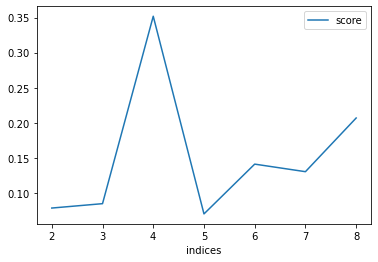

In [41]:
# gca stands for 'get current axis'
ax = plt.gca()

ind_sco_df.plot(kind='line',x='indices',y='score',ax=ax)

### Even though, 4 is the optimal cluster number, let's pick a little bit more, let's say 8 clusters

In [94]:
best_cluster_num = 8

### Run k-means clustering using 'best_cluster_num' cluster's

In [95]:
kmeans = KMeans(n_clusters=best_cluster_num, init = 'k-means++', random_state = 1)
kmeans.fit_predict(st_zagreb_onehot_grouped)
# add clustering labels to neighborhoods_venues_sorted
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
neighborhoods_venues_sorted

,Town,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Split,GK BAČVICE,Boat or Ferry,Café,Mediterranean Restaurant,Italian Restaurant,Bar,Grocery Store,Hostel,Beach,Restaurant,Hotel,1
1,Split,GK BLATINE ŠKRAPE,Café,Bar,Restaurant,Coffee Shop,Grocery Store,Mediterranean Restaurant,Bistro,Pizza Place,Hotel,Eastern European Restaurant,2
2,Split,GK BOL,Hotel,Café,Mediterranean Restaurant,Pizza Place,Surf Spot,Seafood Restaurant,Beach,Cocktail Bar,Restaurant,Campground,1
3,Split,GK BRDA,Cafeteria,Electronics Store,Grocery Store,Big Box Store,Bar,Café,Women's Store,Fast Food Restaurant,Flea Market,Fish Market,0
4,Split,GK GRAD,Mediterranean Restaurant,Restaurant,Bar,Boat or Ferry,Pizza Place,Hostel,Ice Cream Shop,Italian Restaurant,Grocery Store,Plaza,1
5,Split,GK GRIPE,Café,Nightclub,Hotel,Mediterranean Restaurant,Bistro,Bar,Cocktail Bar,Restaurant,Grocery Store,Gastropub,1
6,Split,GK KMAN,Hotel,Fast Food Restaurant,Bar,Café,Mediterranean Restaurant,Pharmacy,Electronics Store,Restaurant,Farmers Market,Casino,1
7,Split,GK KOCUNAR,Bar,Coffee Shop,Grocery Store,Hotel,Cafeteria,Café,Electronics Store,Bakery,Mediterranean Restaurant,Big Box Store,0
8,Split,GK LOKVE,Café,Grocery Store,Coffee Shop,Bar,Eastern European Restaurant,Hotel,Bistro,Snack Place,Donut Shop,Mediterranean Restaurant,1
9,Split,GK LOVRET,Mediterranean Restaurant,Café,Grocery Store,Hostel,Restaurant,Bar,Bakery,Hotel,Ice Cream Shop,Pizza Place,1


### Merge dataframes to add latitude and longitude for each neighborhood

In [96]:
df_merged = full_towns_df.merge(neighborhoods_venues_sorted, on=['Town', 'Neighborhood'])
df_merged

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Donji grad,Zagreb,45.809878,15.977081,Café,Plaza,Restaurant,Bar,Bistro,Theater,Dessert Shop,Hotel,Hostel,Coffee Shop,1
1,Gornji grad - Medveščak,Zagreb,45.839926,15.975096,Eastern European Restaurant,Light Rail Station,Pub,Field,Grocery Store,Eye Doctor,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,5
2,Maksimir,Zagreb,45.833312,16.010151,Grocery Store,Steakhouse,Restaurant,Supermarket,Bus Station,Café,Women's Store,Field,Fast Food Restaurant,Farmers Market,2
3,Peščenica - Žitnjak,Zagreb,45.812034,16.008027,Café,Bar,Restaurant,Dessert Shop,Grocery Store,Mediterranean Restaurant,Hostel,Nightclub,Burger Joint,Eastern European Restaurant,2
4,Novi Zagreb - istok,Zagreb,45.759520,16.007969,Bakery,Café,Diner,Hotel,Train,Restaurant,Paper / Office Supplies Store,Soccer Field,Sushi Restaurant,Women's Store,1
5,Novi Zagreb - zapad,Zagreb,45.776532,15.972081,Café,Bakery,Bar,Clothing Store,Gym,Basketball Court,Soccer Field,Park,Drugstore,Fast Food Restaurant,1
6,Trešnjevka - sjever,Zagreb,45.801108,15.938832,Bar,Café,Bakery,Grocery Store,Restaurant,Liquor Store,Pizza Place,Chinese Restaurant,Cocktail Bar,Supermarket,2
7,Trešnjevka - jug,Zagreb,45.798288,15.947751,Café,Bar,Electronics Store,Bakery,Supermarket,Restaurant,Grocery Store,Drugstore,Pizza Place,Cosmetics Shop,2
8,Črnomerec,Zagreb,45.818301,15.938581,Café,Supermarket,BBQ Joint,Grocery Store,Art Gallery,Pizza Place,IT Services,Bakery,Bar,Eastern European Restaurant,2
9,Gornja Dubrava,Zagreb,45.830290,16.043665,Café,Electronics Store,Bar,Pharmacy,Pizza Place,Supermarket,Light Rail Station,Shopping Mall,Burger Joint,Shoe Store,2


In [97]:
def drow_cluster_map(address, df_town, best_cluster_num):
    # create map
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters    
    x = np.arange(best_cluster_num)
    ys = [i + x + (i*x)**2 for i in range(best_cluster_num)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_town['latitude'], df_town['longitude'], df_town['Neighborhood'], df_town['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)       
    return map_clusters

### Create map for Zagreb

In [98]:
df_town = df_merged[df_merged['Town'] == 'Zagreb'].copy()
address = 'Zagreb, Croatia'
map_clusters = drow_cluster_map(address, df_town, best_cluster_num)
map_clusters

### Create map for Split

In [99]:
df_town = df_merged[df_merged['Town'] == 'Split'].copy()
address = 'Split, Croatia'
map_clusters = drow_cluster_map(address, df_town, best_cluster_num)
map_clusters

# 4. Examining our clusters

### Cluster 1

In [100]:
df_merged.loc[df_merged['Cluster Labels'] == 0, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
19,GK BRDA,Split,43.524406,16.469173,Cafeteria,Electronics Store,Grocery Store,Big Box Store,Bar,Café,Women's Store,Fast Food Restaurant,Flea Market,Fish Market,0
23,GK KOCUNAR,Split,43.518404,16.466329,Bar,Coffee Shop,Grocery Store,Hotel,Cafeteria,Café,Electronics Store,Bakery,Mediterranean Restaurant,Big Box Store,0
33,GK RAVNE NJIVE,Split,43.520391,16.470187,Grocery Store,Electronics Store,Cafeteria,Bakery,Bar,Café,Big Box Store,Women's Store,Field,Food,0


### Cluster 2

In [101]:
df_merged.loc[df_merged['Cluster Labels'] == 1, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Donji grad,Zagreb,45.809878,15.977081,Café,Plaza,Restaurant,Bar,Bistro,Theater,Dessert Shop,Hotel,Hostel,Coffee Shop,1
4,Novi Zagreb - istok,Zagreb,45.759520,16.007969,Bakery,Café,Diner,Hotel,Train,Restaurant,Paper / Office Supplies Store,Soccer Field,Sushi Restaurant,Women's Store,1
5,Novi Zagreb - zapad,Zagreb,45.776532,15.972081,Café,Bakery,Bar,Clothing Store,Gym,Basketball Court,Soccer Field,Park,Drugstore,Fast Food Restaurant,1
10,Donja Dubrava,Zagreb,45.816409,16.069855,Supermarket,Train Station,Electronics Store,Bakery,Bus Station,Women's Store,Falafel Restaurant,Flea Market,Fish Market,Field,1
16,GK BAČVICE,Split,43.503843,16.447226,Boat or Ferry,Café,Mediterranean Restaurant,Italian Restaurant,Bar,Grocery Store,Hostel,Beach,Restaurant,Hotel,1
18,GK BOL,Split,43.260519,16.652019,Hotel,Café,Mediterranean Restaurant,Pizza Place,Surf Spot,Seafood Restaurant,Beach,Cocktail Bar,Restaurant,Campground,1
20,GK GRAD,Split,43.508823,16.439191,Mediterranean Restaurant,Restaurant,Bar,Boat or Ferry,Pizza Place,Hostel,Ice Cream Shop,Italian Restaurant,Grocery Store,Plaza,1
21,GK GRIPE,Split,43.508104,16.452655,Café,Nightclub,Hotel,Mediterranean Restaurant,Bistro,Bar,Cocktail Bar,Restaurant,Grocery Store,Gastropub,1
22,GK KMAN,Split,43.518244,16.455989,Hotel,Fast Food Restaurant,Bar,Café,Mediterranean Restaurant,Pharmacy,Electronics Store,Restaurant,Farmers Market,Casino,1
24,GK LOKVE,Split,43.510582,16.458608,Café,Grocery Store,Coffee Shop,Bar,Eastern European Restaurant,Hotel,Bistro,Snack Place,Donut Shop,Mediterranean Restaurant,1


### Cluster 3

In [102]:
df_merged.loc[df_merged['Cluster Labels'] == 2, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
2,Maksimir,Zagreb,45.833312,16.010151,Grocery Store,Steakhouse,Restaurant,Supermarket,Bus Station,Café,Women's Store,Field,Fast Food Restaurant,Farmers Market,2
3,Peščenica - Žitnjak,Zagreb,45.812034,16.008027,Café,Bar,Restaurant,Dessert Shop,Grocery Store,Mediterranean Restaurant,Hostel,Nightclub,Burger Joint,Eastern European Restaurant,2
6,Trešnjevka - sjever,Zagreb,45.801108,15.938832,Bar,Café,Bakery,Grocery Store,Restaurant,Liquor Store,Pizza Place,Chinese Restaurant,Cocktail Bar,Supermarket,2
7,Trešnjevka - jug,Zagreb,45.798288,15.947751,Café,Bar,Electronics Store,Bakery,Supermarket,Restaurant,Grocery Store,Drugstore,Pizza Place,Cosmetics Shop,2
8,Črnomerec,Zagreb,45.818301,15.938581,Café,Supermarket,BBQ Joint,Grocery Store,Art Gallery,Pizza Place,IT Services,Bakery,Bar,Eastern European Restaurant,2
9,Gornja Dubrava,Zagreb,45.830290,16.043665,Café,Electronics Store,Bar,Pharmacy,Pizza Place,Supermarket,Light Rail Station,Shopping Mall,Burger Joint,Shoe Store,2
11,Stenjevec,Zagreb,45.815391,15.887082,Café,Grocery Store,Bar,Pizza Place,Soccer Field,Sports Club,Supermarket,Park,Plaza,Restaurant,2
12,Podsused - Vrapče,Zagreb,45.818406,15.841420,Café,Pizza Place,Bus Station,Basketball Court,Bar,Grocery Store,Bakery,Athletics & Sports,Train Station,Pub,2
14,Sesvete,Zagreb,45.827605,16.108984,Café,Grocery Store,Furniture / Home Store,Cosmetics Shop,Eastern European Restaurant,BBQ Joint,Pizza Place,Electronics Store,Big Box Store,Women's Store,2
17,GK BLATINE ŠKRAPE,Split,43.507784,16.460230,Café,Bar,Restaurant,Coffee Shop,Grocery Store,Mediterranean Restaurant,Bistro,Pizza Place,Hotel,Eastern European Restaurant,2


### Cluster 4

In [103]:
df_merged.loc[df_merged['Cluster Labels'] == 3, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
28,GK MEJAŠI,Split,43.516981,16.488799,Clothing Store,Café,Fast Food Restaurant,Supermarket,Cocktail Bar,Toy / Game Store,Shopping Mall,Women's Store,Field,Farmers Market,3
30,GK NESLANOVAC,Split,43.522515,16.480000,Grocery Store,Fast Food Restaurant,Clothing Store,Multiplex,Cocktail Bar,Shopping Mall,Toy / Game Store,Café,Pet Store,Field,3
32,GK PUJANKE,Split,43.516933,16.475140,Grocery Store,Fast Food Restaurant,Clothing Store,Café,Pizza Place,Shopping Mall,Electronics Store,Bakery,Bar,Toy / Game Store,3
34,GK SIROBUJA,Split,43.508119,16.509434,Grocery Store,Multiplex,Pizza Place,Fast Food Restaurant,Mobile Phone Shop,Restaurant,Bar,Food Court,Clothing Store,Pet Store,3
41,GK VISOKA,Split,43.512741,16.478193,Grocery Store,Park,Fast Food Restaurant,Irish Pub,Asian Restaurant,Athletics & Sports,Café,Bakery,Bar,Pizza Place,3


### Cluster 5

In [104]:
df_merged.loc[df_merged['Cluster Labels'] == 4, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
15,Brezovica,Zagreb,45.727649,15.911798,Bus Station,Historic Site,Bar,Pharmacy,Women's Store,Eye Doctor,Fish Market,Field,Fast Food Restaurant,Farmers Market,4


### Cluster 6

In [105]:
df_merged.loc[df_merged['Cluster Labels'] == 5, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Gornji grad - Medveščak,Zagreb,45.839926,15.975096,Eastern European Restaurant,Light Rail Station,Pub,Field,Grocery Store,Eye Doctor,Flea Market,Fish Market,Fast Food Restaurant,Farmers Market,5


### Cluster 7

In [106]:
df_merged.loc[df_merged['Cluster Labels'] == 6, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
13,Podsljeme,Zagreb,45.888748,15.984549,Trail,Café,Women's Store,Eye Doctor,Flea Market,Fish Market,Field,Fast Food Restaurant,Farmers Market,Falafel Restaurant,6


### Cluster 8

In [107]:
df_merged.loc[df_merged['Cluster Labels'] == 7, :]

,Neighborhood,Town,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
38,GK ŠINE,Split,43.509022,16.526012,Beach,Italian Restaurant,Pizza Place,Mediterranean Restaurant,Campground,Women's Store,Falafel Restaurant,Flea Market,Fish Market,Field,7


# 5. Conclusion

It's obvious that there is an overlaping of neighborhoods in Split and Zagreb in clusters '2' and '3'.  
Clusters '1', '4' and '8' are unique Split neighborhoods, lying on the outher city's ring.  
Clusters '5', '6' and '7' are unique Zagreb neighborhoods.